# **04 - Modeling & Evaluation**

In [ ]:
import sys
sys.path.insert(0, "../src")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from dataset import Dataset

pd.set_option("display.max_columns", None)

## **Normalization**

Each year must produce the exact same column set regardless of its format group.

In [ ]:
from dataset import (
    CANONICAL_CHARACTERISTICS,
    CANONICAL_LOCATIONS,
    CANONICAL_VEHICLES,
    CANONICAL_USERS,
)

for y in list(range(2010, 2023)) + ["test"]:
    ds = Dataset(y)
    assert ds.characteristics.columns.tolist() == CANONICAL_CHARACTERISTICS, f"{y}: characteristics columns mismatch"
    assert ds.locations.columns.tolist() == CANONICAL_LOCATIONS, f"{y}: locations columns mismatch"
    assert ds.vehicles.columns.tolist() == CANONICAL_VEHICLES, f"{y}: vehicles columns mismatch"
    assert ds.users.columns.tolist() == CANONICAL_USERS, f"{y}: users columns mismatch"
    n_acc = ds.characteristics["Num_Acc"].nunique()
    print(f"{str(y):5s} (group {ds.group}) : {n_acc:>6,} accidents  OK")

print("\nAll years normalized successfully.")

### **Build full training set**

In [ ]:
train = pd.concat(
    [Dataset(y).merged() for y in range(2010, 2023)],
    ignore_index=True,
)
print(f"Full training set: {train.shape[0]:,} rows x {train.shape[1]} cols")
print(f"Unique accidents:  {train['Num_Acc'].nunique():,}")
train.head()

## **Feature Engineering**

### **Target variable: GRAVE**

Create a binary target at the **accident level**: `GRAVE = 1` if at least one user was killed (`grav=2`) or hospitalized (`grav=3`), `0` otherwise. We use `groupby("Num_Acc").transform("max")` to propagate the label to every row of the same accident.

In [ ]:
train["GRAVE"] = train["grav"].isin([2, 3]).astype(int)
train["GRAVE"] = train.groupby("Num_Acc")["GRAVE"].transform("max")
train.drop(columns=["grav"], inplace=True)
train["GRAVE"].value_counts()

### **Accident-level aggregation features**

Count features derived from `groupby("Num_Acc")`:
- `nb_vehicules` — number of distinct vehicles involved
- `nb_usagers` — total number of users (drivers, passengers, pedestrians)
- `nb_pietons` — number of pedestrians (`catu == 3`)
- `nb_occupants_vehicule` — number of non-pedestrian users per vehicle (`catu != 3`), to avoid counting pedestrians who are linked to a vehicle only because the accident involves them

In [ ]:
# Per accident
train["nb_vehicules"] = train.groupby("Num_Acc")["num_veh"].transform("nunique")
train["nb_usagers"]   = train.groupby("Num_Acc")["catu"].transform("count")
train["nb_pietons"]   = train.groupby("Num_Acc")["catu"].transform(lambda x: (x == 3).sum())

# Per vehicle: count only non-pedestrians (catu != 3)
occupants = (
    train[train["catu"] != 3]
    .groupby(["Num_Acc", "num_veh"])
    .size()
    .rename("nb_occupants_vehicule")
)
train = train.merge(occupants, on=["Num_Acc", "num_veh"], how="left")
train["nb_occupants_vehicule"] = train["nb_occupants_vehicule"].fillna(0).astype(int)

### **Individual-level features**

Derive per-user attributes from existing columns:
- `age` — age at the time of the accident (`an - an_nais`). Values outside [0, 120] are set to NaN as data entry errors.

In [ ]:
train["age"] = train["an"] - train["an_nais"]
train.loc[(train["age"] < 0) | (train["age"] > 120), "age"] = np.nan

print(f"age NaN: {train['age'].isna().sum():,} ({train['age'].isna().mean():.2%})")

### **Drop low-value columns**

Remove free-text, identifier, and high-cardinality string columns that carry no direct predictive signal for a tree-based model:

| Column | Reason |
|--------|--------|
| `voie` | Road name/number — free-text, very high cardinality |
| `v1`, `v2` | Alphanumeric road index points — free-text identifiers |
| `pr`, `pr1` | Milestone references (bornes kilométriques) — numeric road markers, not meaningful as features |
| `com` | Commune code — inconsistent format across groups (3-digit vs full INSEE), high cardinality (~36k unique). Geographic info already captured by `dep` |

Note: `adr`, `lat`, `long` were already dropped during normalization (free-text address and incompatible coordinate systems).

In [ ]:
drop_cols = ["voie", "v1", "v2", "pr", "pr1", "com"]
train.drop(columns=drop_cols, inplace=True)

### **Variable transformations**

- `hrmn` (integer HHMM) → extract `hour` (0-23), then drop `hrmn`
- `lartpc`, `larrout` — road widths stored as strings → convert to numeric
- `an_nais` — redundant with `age` → drop

In [ ]:
# Extract hour from HHMM
train["hour"] = train["hrmn"] // 100

# Convert road widths to numeric
for col in ("lartpc", "larrout"):
    train[col] = pd.to_numeric(train[col], errors="coerce")

# Drop redundant columns
train.drop(columns=["hrmn", "an_nais"], inplace=True)

### **Drop identifiers**

`Num_Acc` and `num_veh` are row identifiers with no predictive value. Dropped after all groupby-based features have been computed.

In [ ]:
train.drop(columns=["Num_Acc", "num_veh"], inplace=True)

## **Modeling — LightGBM**

### **Train / Validation split**

80/20 stratified split on `GRAVE` to preserve class proportions.

In [ ]:
TARGET = "GRAVE"

y = train[TARGET]
X = train.drop(columns=[TARGET])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y,
)

print(f"Train: {X_train.shape[0]:,} rows  |  Val: {X_val.shape[0]:,} rows")
print(f"Train GRAVE rate: {y_train.mean():.3f}  |  Val GRAVE rate: {y_val.mean():.3f}")

### **Categorical features**

LightGBM handles categorical features natively. We declare all integer-coded categorical columns and convert `dep` (string department code) to `category` dtype.

In [ ]:
CAT_FEATURES = [
    # characteristics
    "mois", "jour", "lum", "agg", "int", "atm", "col", "dep",
    # locations
    "catr", "circ", "vosp", "prof", "plan", "surf", "infra", "situ",
    # vehicles
    "senc", "catv", "obs", "obsm", "choc", "manv",
    # users
    "place", "catu", "sexe", "trajet", "secu1", "locp", "actp", "etatp",
    # engineered
    "hour",
]

for col in CAT_FEATURES:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")

print(f"Categorical features: {len(CAT_FEATURES)}")
print(f"Numeric features:     {X_train.shape[1] - len(CAT_FEATURES)}")
print(f"Total features:       {X_train.shape[1]}")

### **LightGBM Datasets**

Build native `lgb.Dataset` objects with categorical feature declarations for optimal split finding.

In [13]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_FEATURES, free_raw_data=False)
dval   = lgb.Dataset(X_val,   label=y_val,   categorical_feature=CAT_FEATURES, reference=dtrain, free_raw_data=False)

### **Training**

Baseline LightGBM with `is_unbalance=True` to handle the class imbalance. Early stopping on validation AUC to avoid overfitting.

In [14]:
params = {
    "objective": "binary",
    "metric": "auc",
    "is_unbalance": True,
    "learning_rate": 0.05,
    "num_leaves": 63,
    "max_depth": -1,
    "min_child_samples": 50,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1,
    "seed": 42,
}

callbacks = [
    lgb.log_evaluation(period=100),
    lgb.early_stopping(stopping_rounds=100),
]

model = lgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    valid_sets=[dtrain, dval],
    valid_names=["train", "val"],
    callbacks=callbacks,
)

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best val AUC:   {model.best_score['val']['auc']:.4f}")

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.833808	val's auc: 0.831379
[200]	train's auc: 0.846959	val's auc: 0.841181
[300]	train's auc: 0.854599	val's auc: 0.846368
[400]	train's auc: 0.859549	val's auc: 0.849404
[500]	train's auc: 0.863808	val's auc: 0.852043
[600]	train's auc: 0.867325	val's auc: 0.854156
[700]	train's auc: 0.870724	val's auc: 0.856098
[800]	train's auc: 0.873877	val's auc: 0.857949
[900]	train's auc: 0.876804	val's auc: 0.859604
[1000]	train's auc: 0.879776	val's auc: 0.861324
[1100]	train's auc: 0.882554	val's auc: 0.862912
[1200]	train's auc: 0.885262	val's auc: 0.864423
[1300]	train's auc: 0.887841	val's auc: 0.86592
[1400]	train's auc: 0.89033	val's auc: 0.867372
[1500]	train's auc: 0.892731	val's auc: 0.868706
[1600]	train's auc: 0.89498	val's auc: 0.869975
[1700]	train's auc: 0.897157	val's auc: 0.871144
[1800]	train's auc: 0.899277	val's auc: 0.872326
[1900]	train's auc: 0.901413	val's auc: 0.87352
[2000]	train's auc: 

### **Evaluation**

Validation metrics: ROC-AUC, classification report (precision / recall / F1), and confusion matrix.

ROC-AUC: 0.8746

              precision    recall  f1-score   support

   Non grave       0.84      0.81      0.82    186166
       Grave       0.74      0.78      0.76    130604

    accuracy                           0.80    316770
   macro avg       0.79      0.79      0.79    316770
weighted avg       0.80      0.80      0.80    316770



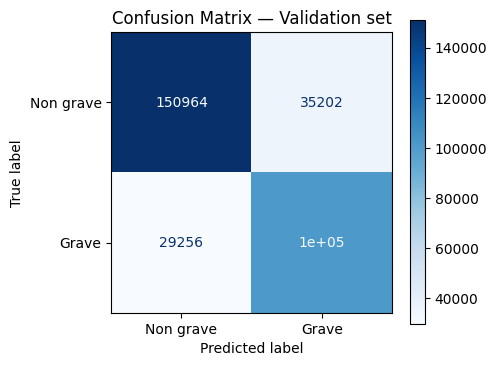

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_prob = model.predict(X_val, num_iteration=model.best_iteration)
y_pred = (y_prob >= 0.5).astype(int)

print(f"ROC-AUC: {roc_auc_score(y_val, y_prob):.4f}\n")
print(classification_report(y_val, y_pred, target_names=["Non grave", "Grave"]))

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred,
    display_labels=["Non grave", "Grave"],
    cmap="Blues", ax=ax,
)
ax.set_title("Confusion Matrix — Validation set")
plt.tight_layout()
plt.show()

### **Feature importance**

Top 20 features ranked by split-based importance (number of times each feature is used in a split).

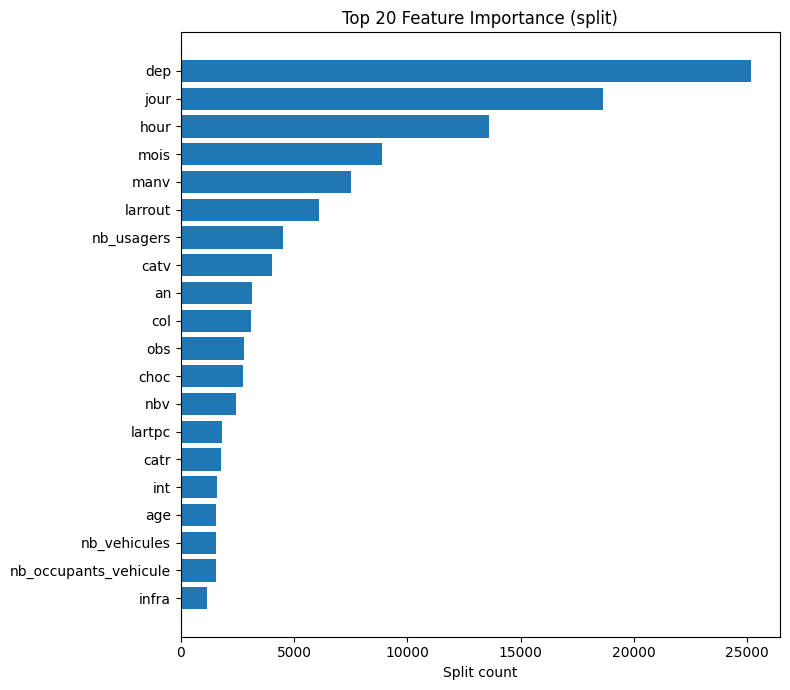

,feature,importance
8,dep,25185
2,jour,18644
40,hour,13584
1,mois,8883
26,manv,7524
16,larrout,6086
36,nb_usagers,4513
21,catv,4010
0,an,3135
7,col,3076


In [16]:
importance = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance(importance_type="split"),
}).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(8, 7))
top = importance.head(20)
ax.barh(top["feature"][::-1], top["importance"][::-1])
ax.set_xlabel("Split count")
ax.set_title("Top 20 Feature Importance (split)")
plt.tight_layout()
plt.show()

importance.head(20)

### **Save the model**

In [18]:
model.save_model("../models/lgbm_grave.txt")